# Supervised Learning - Sales Forecast

In [1]:
import warnings
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [2]:
# This gist contains a direct connection to a local PostgreSQL database
# called "suppliers" where the username and password parameters are "postgres"

# This code is adapted from the tutorial hosted below:
# http://www.postgresqltutorial.com/postgresql-python/connect/


# Establish a connection to the database by creating a cursor object
# The PostgreSQL server must be accessed through the PostgreSQL APP or Terminal Shell

# conn = psycopg2.connect("dbname=suppliers port=5432 user=postgres password=postgres")

# Or:
conn = psycopg2.connect(host="localhost", port = 5432, database="ecommerce", user="postgres", password="b197eas")

# Create a cursor object
cur = conn.cursor()

# A sample query of all data from the "vendors" table in the "suppliers" database
cur.execute("""SELECT * FROM public.feedback LIMIT 5""")
query_results = cur.fetchall()
print(query_results)

# # Close the cursor and connection to so the server can allocate
# # bandwidth to other requests
# cur.close()
# conn.close()

[('7bc2406110b926393aa56f80a40eba40', '73fc7af87114b39712e6da79b0a377eb', 4, datetime.datetime(2018, 1, 18, 0, 0), datetime.datetime(2018, 1, 18, 21, 46, 59)), ('80e641a11e56f04c1ad469d5645fdfde', 'a548910a1c6147796b98fdf73dbeba33', 5, datetime.datetime(2018, 3, 10, 0, 0), datetime.datetime(2018, 3, 11, 3, 5, 13)), ('228ce5500dc1d8e020d8d1322874b6f0', 'f9e4b658b201a9f2ecdecbb34bed034b', 5, datetime.datetime(2018, 2, 17, 0, 0), datetime.datetime(2018, 2, 18, 14, 36, 24)), ('e64fb393e7b32834bb789ff8bb30750e', '658677c97b385a9be170737859d3511b', 5, datetime.datetime(2017, 4, 21, 0, 0), datetime.datetime(2017, 4, 21, 22, 2, 6)), ('f7c4243c7fe1938f181bec41a392bdeb', '8e6bfb81e283fa7e4f11123a3fb894f1', 5, datetime.datetime(2018, 3, 1, 0, 0), datetime.datetime(2018, 3, 2, 10, 26, 53))]


In [3]:
cur.execute("""
SELECT 
    sales,
    full_date,
    day_of_week,
    day_num_in_month,
    day_num_overall,
    weekday_flag,
    week_num_in_year,
    week_num_overall,
    month,
    month_num_overall,
    quarter,
    year
FROM datawarehouse.fact_sales fs,datawarehouse.dim_date dd
WHERE fs.order_date_key = dd.date_key
""")
query_results = cur.fetchall()
df = pd.DataFrame (query_results, columns =[
    'sales',
    'full_date',
    'day_of_week',
    'day_num_in_month',
    'day_num_overall',
    'weekday_flag',
    'week_num_in_year',
    'week_num_overall',
    'month',
    'month_num_overall',
    'quarter',
    'year'
])
df.head()

,sales,full_date,day_of_week,day_num_in_month,day_num_overall,weekday_flag,week_num_in_year,week_num_overall,month,month_num_overall,quarter,year
0,92500.0,2018-01-15,1,15,746,Weekday,3,109,1,25,1,2018
1,74000.0,2018-08-24,5,24,967,Weekday,34,140,8,32,3,2018
2,151900.0,2017-10-24,2,24,663,Weekday,44,97,10,22,4,2017
3,119700.0,2018-03-19,1,19,809,Weekday,12,118,3,27,1,2018
4,24990.0,2018-01-06,6,6,737,Weekend,1,107,1,25,1,2018


## EDA

In [4]:
# Create fresh copy of df
df_sales = df.copy()
df_sales['full_date'] = pd.to_datetime(df_sales['full_date'])
#represent month in date field as its first day
df_sales['full_date'] = df_sales['full_date'].dt.year.astype('str') + '-' + df_sales['full_date'].dt.month.astype('str') + '-01'
df_sales['full_date'] = pd.to_datetime(df_sales['full_date'])
#groupby date and sum the sales
df_sales = df_sales.groupby('full_date').sales.sum().reset_index()

In [5]:
df_sales

,full_date,sales
0,2016-09-01,2.673600e+05
1,2016-10-01,4.950766e+07
2,2016-12-01,1.090000e+04
3,2017-01-01,1.203129e+08
4,2017-02-01,2.473030e+08
5,2017-03-01,3.743443e+08
6,2017-04-01,3.599272e+08
7,2017-05-01,5.060711e+08
8,2017-06-01,4.330386e+08
9,2017-07-01,4.980315e+08


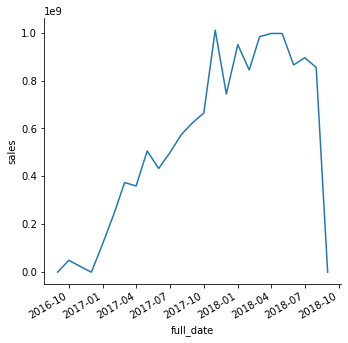

In [6]:
g = sns.relplot(x="full_date", y="sales", kind="line", data=df_sales)
g.fig.autofmt_xdate()

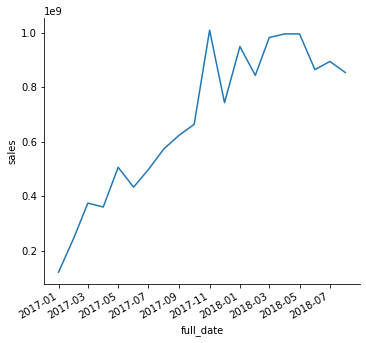

In [7]:
# Remove 2016 and September 2018
# beacuse number of sales is very low
df_sales2 = df_sales.head(23).tail(20)
x = sns.relplot(x="full_date", y="sales", kind="line", data=df_sales2)
x.fig.autofmt_xdate()

## Features Engineering

### Add day in year Feature

In [8]:
# Data from 2016 - 2018
# If 2016, day overall - 0
# If 2017, day overall- 366
# If 2018, day overall - 366 - 365

df.loc[df['year'] == 2016, 'day_num_in_year'] = df['day_num_overall']
df.loc[df['year'] == 2017, 'day_num_in_year'] = df['day_num_overall'] - 366
df.loc[df['year'] == 2018, 'day_num_in_year'] = df['day_num_overall'] - 366 - 365
df['day_num_in_year'] = df['day_num_in_year'].astype(int)
df.head()

,sales,full_date,day_of_week,day_num_in_month,day_num_overall,weekday_flag,week_num_in_year,week_num_overall,month,month_num_overall,quarter,year,day_num_in_year
0,92500.0,2018-01-15,1,15,746,Weekday,3,109,1,25,1,2018,15
1,74000.0,2018-08-24,5,24,967,Weekday,34,140,8,32,3,2018,236
2,151900.0,2017-10-24,2,24,663,Weekday,44,97,10,22,4,2017,297
3,119700.0,2018-03-19,1,19,809,Weekday,12,118,3,27,1,2018,78
4,24990.0,2018-01-06,6,6,737,Weekend,1,107,1,25,1,2018,6


### Week in Month

In [9]:
df.loc[df['day_num_in_month'] >= 1, 'week_num_in_month'] = 1
df.loc[df['day_num_in_month'] >= 8, 'week_num_in_month'] = 2
df.loc[df['day_num_in_month'] >= 15, 'week_num_in_month'] = 3
df.loc[df['day_num_in_month'] >= 22, 'week_num_in_month'] = 4
df['week_num_in_month'] = df['week_num_in_month'].astype(int)
df.head()

,sales,full_date,day_of_week,day_num_in_month,day_num_overall,weekday_flag,week_num_in_year,week_num_overall,month,month_num_overall,quarter,year,day_num_in_year,week_num_in_month
0,92500.0,2018-01-15,1,15,746,Weekday,3,109,1,25,1,2018,15,3
1,74000.0,2018-08-24,5,24,967,Weekday,34,140,8,32,3,2018,236,4
2,151900.0,2017-10-24,2,24,663,Weekday,44,97,10,22,4,2017,297,4
3,119700.0,2018-03-19,1,19,809,Weekday,12,118,3,27,1,2018,78,3
4,24990.0,2018-01-06,6,6,737,Weekend,1,107,1,25,1,2018,6,1


### Convert Weekday flag to 1s and 0s

In [10]:
df.loc[df['weekday_flag'] == 'Weekday', 'weekday_flag'] = 1
df.loc[df['weekday_flag'] == 'Weekend', 'weekday_flag'] = 0
df.head()

,sales,full_date,day_of_week,day_num_in_month,day_num_overall,weekday_flag,week_num_in_year,week_num_overall,month,month_num_overall,quarter,year,day_num_in_year,week_num_in_month
0,92500.0,2018-01-15,1,15,746,1,3,109,1,25,1,2018,15,3
1,74000.0,2018-08-24,5,24,967,1,34,140,8,32,3,2018,236,4
2,151900.0,2017-10-24,2,24,663,1,44,97,10,22,4,2017,297,4
3,119700.0,2018-03-19,1,19,809,1,12,118,3,27,1,2018,78,3
4,24990.0,2018-01-06,6,6,737,0,1,107,1,25,1,2018,6,1


### Checking relationship between Features and Sales

In [11]:
features_list1 = [
    'full_date',
    'day_of_week',
    'day_num_in_month',
    'day_num_overall',
    'weekday_flag',
    'day_num_in_year'
   
    ]
features_list2 = [
    'week_num_in_year',
    'week_num_overall',
    'month',
    'month_num_overall',
    'quarter',
    'year',
    'week_num_in_month'
    
]


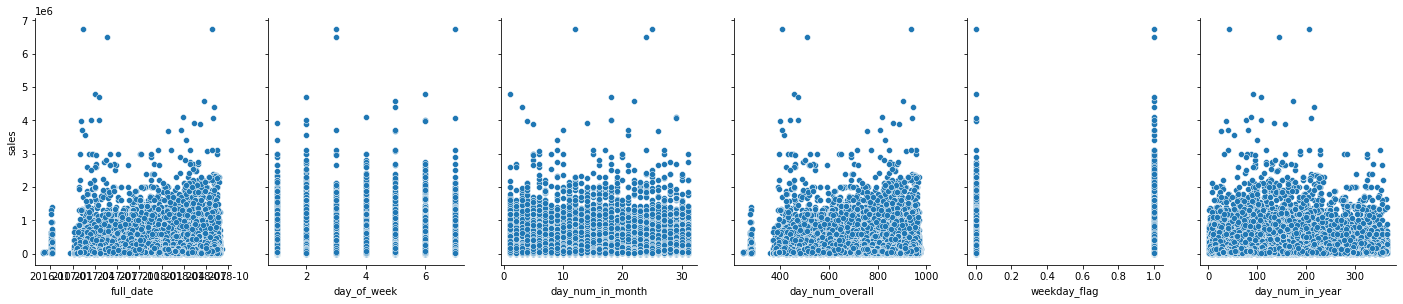

In [12]:
g = sns.pairplot(data=df, x_vars=features_list1,
             y_vars='sales')
g.fig.set_size_inches(20,5)

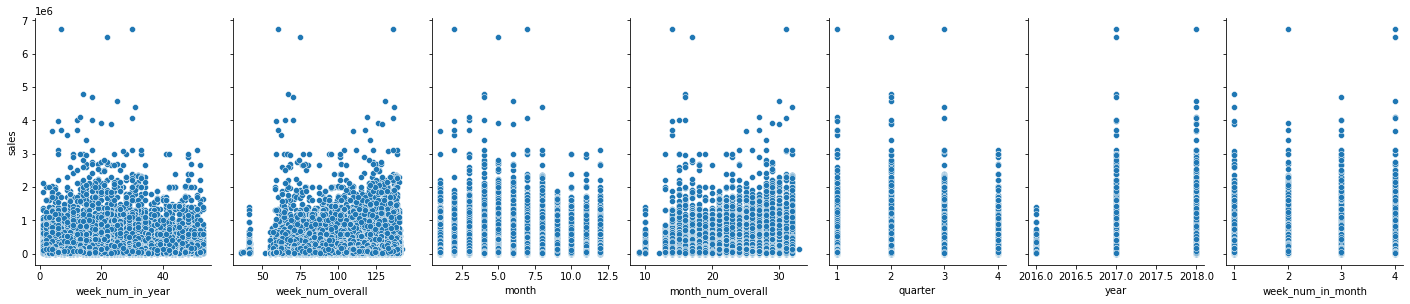

In [13]:
g = sns.pairplot(data=df, x_vars=features_list2,
             y_vars='sales')
g.fig.set_size_inches(20,5)

<AxesSubplot:>

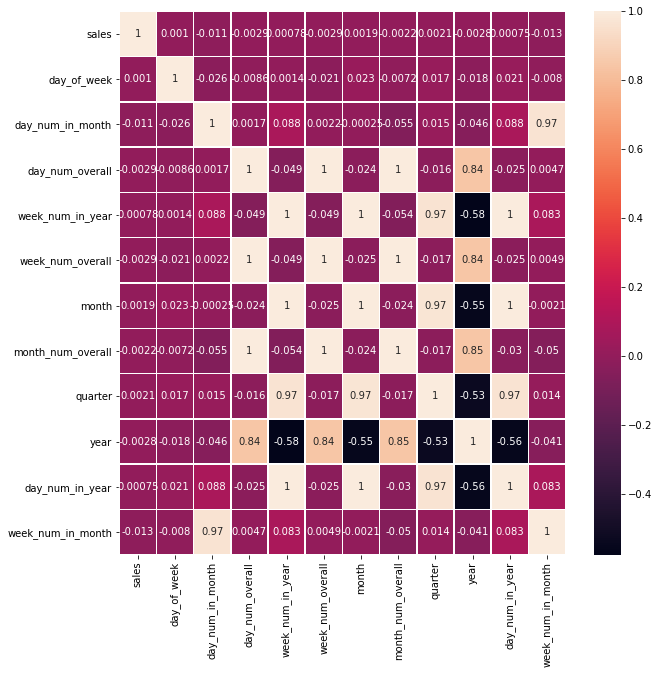

In [14]:
# Viewing the heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df.corr(), annot=True,linewidths=.5, ax=ax)

<AxesSubplot:>

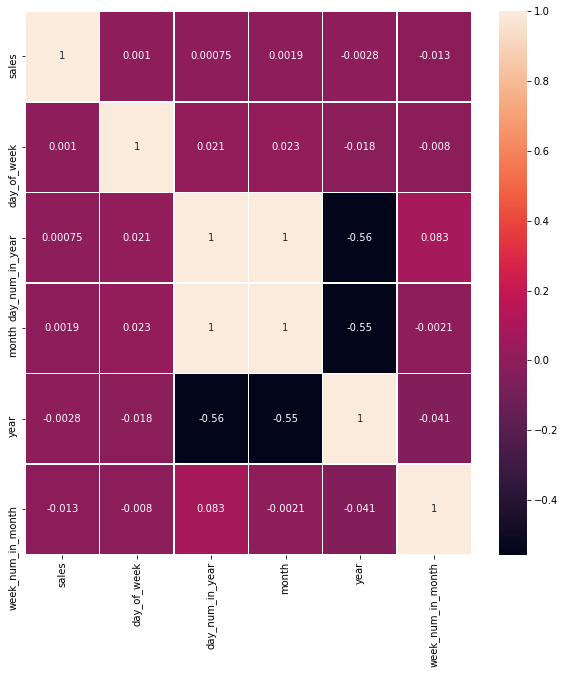

In [15]:
# Remove Collinear Features
# Month or day num in year is not removed for analytical purposes
df2 = df[[
    'full_date',
    'sales',
    'day_of_week',
    'weekday_flag',
    'day_num_in_year', 
    'month',
    'year',
    'week_num_in_month'
         ]]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df2.corr(), annot=True,linewidths=.5, ax=ax)

## Pre-Processing

## Aggregate to Daily Sales

In [16]:
from pandasql import sqldf
full_dataset = sqldf("""select full_date,sum(sales),day_of_week,weekday_flag,day_num_in_year,month,year,week_num_in_month
               from df
               group by full_date""")
full_dataset

,full_date,sum(sales),day_of_week,weekday_flag,day_num_in_year,month,year,week_num_in_month
0,2016-09-04,72890.0,7,0,248,9,2016,1
1,2016-09-05,59500.0,1,1,249,9,2016,1
2,2016-09-15,134970.0,4,1,259,9,2016,3
3,2016-10-02,100000.0,7,0,276,10,2016,1
4,2016-10-03,463480.0,1,1,277,10,2016,1
...,...,...,...,...,...,...,...,...
611,2018-08-26,8070710.0,7,0,238,8,2018,4
612,2018-08-27,5345910.0,1,1,239,8,2018,4
613,2018-08-28,3673910.0,2,1,240,8,2018,4
614,2018-08-29,1546040.0,3,1,241,8,2018,4


### Features Selection (?)

In [17]:
sales = full_dataset['sum(sales)']
dataset = full_dataset.drop(['sum(sales)'], axis=1)
dataset.head()

,full_date,day_of_week,weekday_flag,day_num_in_year,month,year,week_num_in_month
0,2016-09-04,7,0,248,9,2016,1
1,2016-09-05,1,1,249,9,2016,1
2,2016-09-15,4,1,259,9,2016,3
3,2016-10-02,7,0,276,10,2016,1
4,2016-10-03,1,1,277,10,2016,1


In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
def select_features(X_train, y_train):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs

In [19]:
X_train = dataset.drop(['full_date'], axis=1)
y_train = sales
X_train_fs, fs = select_features(X_train, y_train)

In [20]:
X_train

,day_of_week,weekday_flag,day_num_in_year,month,year,week_num_in_month
0,7,0,248,9,2016,1
1,1,1,249,9,2016,1
2,4,1,259,9,2016,3
3,7,0,276,10,2016,1
4,1,1,277,10,2016,1
...,...,...,...,...,...,...
611,7,0,238,8,2018,4
612,1,1,239,8,2018,4
613,2,1,240,8,2018,4
614,3,1,241,8,2018,4


In [21]:
fs.scores_

array([ 30.20357023,  32.92706095,   6.34712423,   6.82281295,
       281.9564688 ,   0.4884009 ])

day_of_week : 30.203570
weekday_flag : 32.927061
day_num_in_year : 6.347124
month : 6.822813
year : 281.956469
week_num_in_month : 0.488401


<AxesSubplot:>

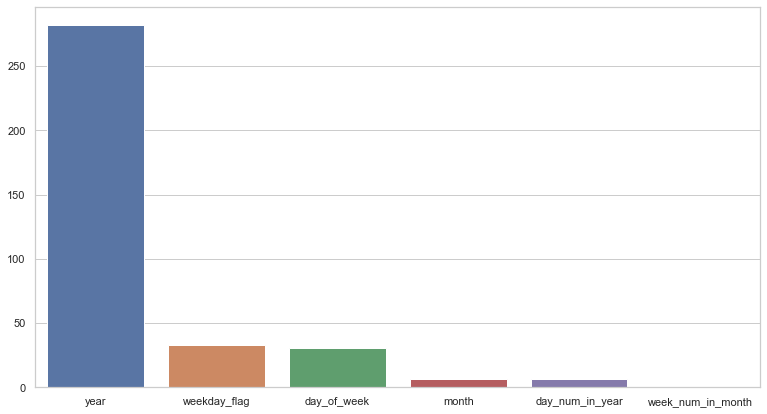

In [22]:
from matplotlib import pyplot
import seaborn as sns
feature_list = [ 'day_of_week', 'weekday_flag', 'day_num_in_year', 'month','year', 'week_num_in_month']
x = 0
for i in feature_list:
    print(i, ': %f' % (fs.scores_[x]))
    x = x+1
#     print('Feature %d: %f' % (i, fs.scores_[i]))

sorted_data = np.sort(fs.scores_)[::-1]
sorted_feature = ['year', 'weekday_flag','day_of_week', 'month', 'day_num_in_year', 'week_num_in_month']
# plot the scores
sns.set(rc={'figure.figsize':(13,7)})

sns.set_theme(style="whitegrid")
sns.barplot(x=[i for i in sorted_feature], y=sorted_data)


### Split into training and test set

Observations: 308
Training Observations: 154
Testing Observations: 154
Observations: 462
Training Observations: 308
Testing Observations: 154
Observations: 616
Training Observations: 462
Testing Observations: 154


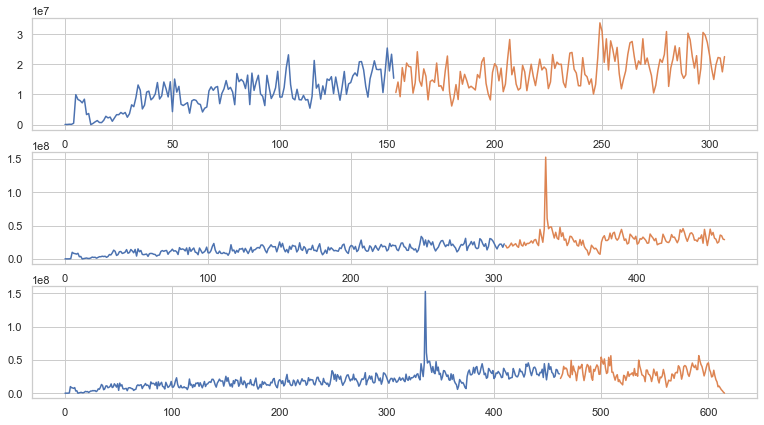

In [23]:
from sklearn.model_selection import TimeSeriesSplit

X = X_train.values
y = y_train.values
y = y.reshape(-1,1)
tscv = TimeSeriesSplit(n_splits=3)

pyplot.figure(1)
index = 1

for train_index, test_index in tscv.split(y):
    train = y[train_index]
    test = y[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
pyplot.show()

### Modelling

#### Baseline

In [26]:
#Baseline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
y_mean  = y.mean()
y_pred_base = [y_mean] * len(y)
mae = mean_absolute_error(y,y_pred_base)
mse = mean_squared_error(y,y_pred_base)
rmse = sqrt(mse)

print (' mae: ',mae, '\n rmse: ', rmse)

 mae:  9554786.12476809 
 rmse:  12583800.462496977


In [27]:
X = X_train
y = y_train

In [28]:
y

0        72890.0
1        59500.0
2       134970.0
3       100000.0
4       463480.0
         ...    
611    8070710.0
612    5345910.0
613    3673910.0
614    1546040.0
615     145000.0
Name: sum(sales), Length: 616, dtype: float64

### Linear Model - Ridge Regression

In [29]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
model = Ridge()
result = cross_val_score(model, X, y, cv=tscv, scoring ='neg_root_mean_squared_error')
rmse = result * -1
result2 = cross_val_score(model, X, y, cv=tscv, scoring ='neg_mean_absolute_error')
mae = result2 * -1
print("RMSE Score: %.2f" % rmse.mean())
print("MAE Score: %.2f" % mae.mean())

RMSE Score: 10773075.24
MAE Score: 7388946.85


#### Parameter Tuning

In [56]:
from sklearn.model_selection import GridSearchCV
from numpy import arange
# define grid
grid = dict()
# grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
# Best config: 0.01

#Testing values between 0 and 1
grid['alpha'] = arange(0, 1, 0.001)

# define search
model = Ridge()
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)

# perform the search
results = search.fit(X, y)
mae = results.best_score_ * -1
print('MAE: %.3f' % mae)
print('Config: %s' % results.best_params_)

# define search
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)

# perform the search
results2 = search.fit(X, y)
rmse = results2.best_score_ * -1

print('RMSE: %.3f' % rmse)
print('Config: %s' % results2.best_params_)

MAE: 7389196.674
Config: {'alpha': 0.999}
RMSE: 10773458.136
Config: {'alpha': 0.999}


In [57]:
search.best_estimator_.coef_

array([ -595432.74434932,  4062359.21512145,   -32644.33274602,
        2371243.77001553, 16341766.05950505,  -208012.29013732])

In [58]:
search.best_estimator_.intercept_

-32953901544.762344

In [59]:
#split train and test set
X_train_set, X_test_set = X_train[0:-154].values, X_train[-154:].values
y_train_set, y_test_actual = sales[0:-154].values, sales[-154:].values

In [60]:
final_model = 
# Predict with best parameter
y_pred = search.predict(X_test_set)

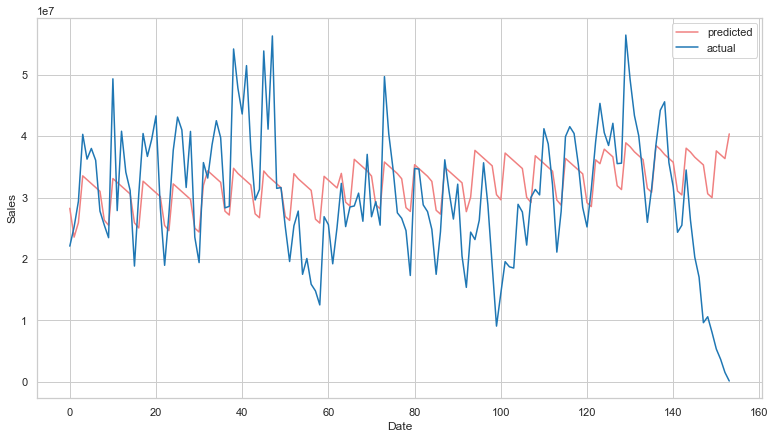

In [61]:
plt.plot(y_pred,color='lightcoral',label='predicted')
plt.plot(y_test_actual,color='tab:blue',label="actual")
plt.xlabel("Date")
plt.ylabel("Sales")
leg = plt.legend()
plt.show()

### SVM

In [62]:
from sklearn.svm import SVR
model = SVR()
result = cross_val_score(model, X, y, cv=tscv, scoring ='neg_root_mean_squared_error')
rmse = result * -1
result2 = cross_val_score(model, X, y, cv=tscv, scoring ='neg_mean_absolute_error')
mae = result2 * -1
print("RMSE Score: %.2f" % rmse.mean())
print("MAE Score: %.2f" % mae.mean())

RMSE Score: 15546020.75
MAE Score: 12700867.20


#### Parameter Tuning

In [63]:
from sklearn.model_selection import GridSearchCV
from numpy import arange
# define grid
grid = {'C': [0.1, 1, 10, 100, 1000], 
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf','linear']
       }

# define search
model = SVR()
search2 = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)

# perform the search
results = search2.fit(X, y)
mae = results.best_score_ * -1
print('MAE: %.3f' % mae)
print('Config: %s' % results.best_params_)

# define search
search2 = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)

# perform the search
results2 = search2.fit(X, y)
rmse = results2.best_score_ * -1

print('RMSE: %.3f' % rmse)
print('Config: %s' % results2.best_params_)

MAE: 12700867.282
Config: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
RMSE: 15546020.809
Config: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


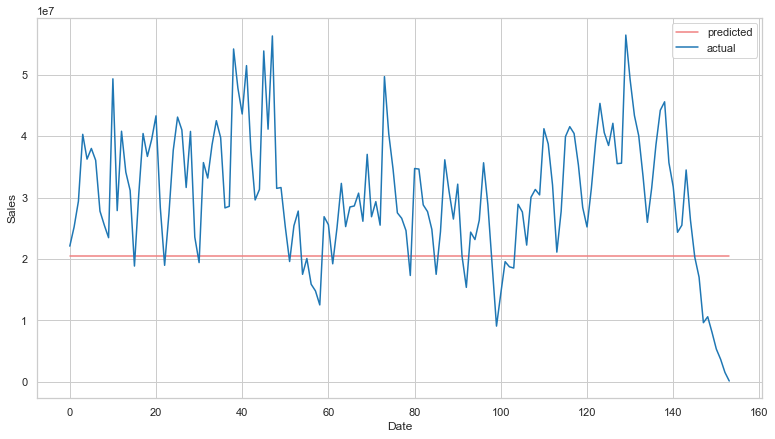

In [64]:
y_pred = search2.predict(X_test_set)

plt.plot(y_pred,color='lightcoral',label='predicted')
plt.plot(y_test_actual,color='tab:blue',label="actual")
plt.xlabel("Date")
plt.ylabel("Sales")
leg = plt.legend()
plt.show()

In [65]:
search2.best_estimator_.intercept_

array([20511455.02291366])

In [66]:
search2.best_estimator_.support_vectors_

array([[7.000e+00, 0.000e+00, 2.480e+02, 9.000e+00, 2.016e+03, 1.000e+00],
       [1.000e+00, 1.000e+00, 2.490e+02, 9.000e+00, 2.016e+03, 1.000e+00],
       [4.000e+00, 1.000e+00, 2.590e+02, 9.000e+00, 2.016e+03, 3.000e+00],
       ...,
       [2.000e+00, 1.000e+00, 2.400e+02, 8.000e+00, 2.018e+03, 4.000e+00],
       [3.000e+00, 1.000e+00, 2.410e+02, 8.000e+00, 2.018e+03, 4.000e+00],
       [1.000e+00, 1.000e+00, 2.460e+02, 9.000e+00, 2.018e+03, 1.000e+00]])

### Random Forest Regressor

In [67]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
result = cross_val_score(model, X, y, cv=tscv, scoring ='neg_root_mean_squared_error')
rmse = result * -1
result2 = cross_val_score(model, X, y, cv=tscv, scoring ='neg_mean_absolute_error')
mae = result2 * -1
print("RMSE Score: %.2f" % rmse.mean())
print("MAE Score: %.2f" % mae.mean())

RMSE Score: 14376215.83
MAE Score: 11500932.68


In [68]:
from sklearn.model_selection import RandomizedSearchCV
# define grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestRegressor(n_jobs=-1)
search = RandomizedSearchCV(model, grid, n_iter = 100,scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)

# perform the search
results = search.fit(X, y)
mae = results.best_score_ * -1
print('MAE: %.3f' % mae)
print('Config: %s' % results.best_params_)


MAE: 10653919.395
Config: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': True}


In [70]:
# Create the random grid
grid = {
    'bootstrap': [False],
    'max_depth': [10, 20, 30, 40],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [1600, 1800, 2000, 2200]
}

model = RandomForestRegressor(n_jobs=-1)
search3 = GridSearchCV(model, grid,scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)

# perform the search
results = search3.fit(X, y)
mae = results.best_score_ * -1
print('MAE: %.3f' % mae)
print('Config: %s' % results.best_params_)


search3_2 = GridSearchCV(model, grid,scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)

# perform the search
results2 = search3_2.fit(X, y)
rmse = results2.best_score_ * -1
print('RMSE: %.3f' % rmse)
print('Config: %s' % results2.best_params_)

MAE: 11255928.577
Config: {'bootstrap': False, 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 1600}
MAE: 14358238.297
Config: {'bootstrap': False, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1800}


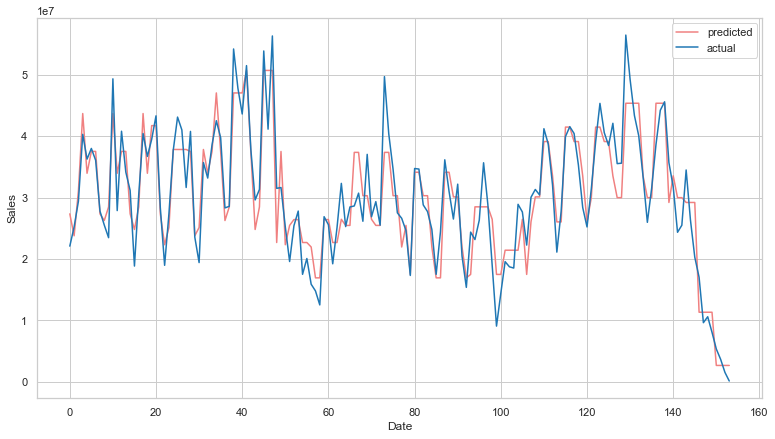

In [78]:
y_pred = search3.predict(X_test_set)

plt.plot(y_pred,color='lightcoral',label='predicted')
plt.plot(y_test_actual,color='tab:blue',label="actual")
plt.xlabel("Date")
plt.ylabel("Sales")
leg = plt.legend()
plt.show()

In [79]:
search3.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 1600}

#### Based on the result, Random Forest Regressor has the best score (MAE of 7336407.191)

### Other Models (Not Used)

In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor()
result = cross_val_score(model, X, y, cv=tscv, scoring ='neg_root_mean_squared_error')
rmse = result * -1
result2 = cross_val_score(model, X, y, cv=tscv, scoring ='neg_mean_absolute_error')
mae = result2 * -1
print("RMSE Score: %.2f" % rmse.mean())
print("MAE Score: %.2f" % mae.mean())

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

model = LinearRegression()
result = cross_val_score(model, X, y, cv=tscv, scoring ='neg_root_mean_squared_error')
rmse = result * -1
result2 = cross_val_score(model, X, y, cv=tscv, scoring ='neg_mean_absolute_error')
mae = result2 * -1
print("RMSE Score: %.2f" % rmse.mean())
print("MAE Score: %.2f" % mae.mean())

In [ ]:
# Takes a While
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = cross_val_score(model, X, y, cv=tscv, scoring ='neg_root_mean_squared_error')
rmse = result * -1
result2 = cross_val_score(model, X, y, cv=tscv, scoring ='neg_mean_absolute_error')
mae = result2 * -1
print("RMSE Score: %.2f" % rmse.mean())
print("MAE Score: %.2f" % mae.mean())

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
result = cross_val_score(model, X, y, cv=tscv, scoring ='neg_root_mean_squared_error')
rmse = result * -1
result2 = cross_val_score(model, X, y, cv=tscv, scoring ='neg_mean_absolute_error')
mae = result2 * -1
print("RMSE Score: %.2f" % rmse.mean())
print("MAE Score: %.2f" % mae.mean())

In [ ]:
from sklearn.svm import SVR
model = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
result = cross_val_score(model, X, y, cv=tscv, scoring ='neg_root_mean_squared_error')
rmse = result * -1
result2 = cross_val_score(model, X, y, cv=tscv, scoring ='neg_mean_absolute_error')
mae = result2 * -1
print("RMSE Score: %.2f" % rmse.mean())
print("MAE Score: %.2f" % mae.mean())

## To do:
2. Model Selection
3. Parameter Tuning
5. Visualize Result